In [125]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

# plt 한국어폰트설정맥북환경 애플고딕
rc('font', family='AppleGothic')

In [126]:
# pip install transformers

In [127]:
# transformers 라이브러리에서 필요한 모듈 임포트
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [128]:
# 모델과 토크나이저 로드
model_name = "pongjin/roberta_with_kornli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [129]:
# 파이프라인 생성
nli_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [130]:
class ArgumentHandler():
    """
    Base interface for handling arguments for each :class:`~transformers.pipelines.Pipeline`.
    """
    def __call__(self, *args, **kwargs):
        raise NotImplementedError()


class CustomZeroShotClassificationArgumentHandler(ArgumentHandler):
    """
    Handles arguments for zero-shot for text classification by turning each possible label into an NLI
    premise/hypothesis pair.
    """

    def _parse_labels(self, labels):
        if isinstance(labels, str):
            labels = [label.strip() for label in labels.split(",")]
        return labels

    def __call__(self, sequences, labels, hypothesis_template):
        if len(labels) == 0 or len(sequences) == 0:
            raise ValueError("You must include at least one label and at least one sequence.")
        if hypothesis_template.format(labels[0]) == hypothesis_template:
            raise ValueError(
                (
                    'The provided hypothesis_template "{}" was not able to be formatted with the target labels. '
                    "Make sure the passed template includes formatting syntax such as {{}} where the label should go."
                ).format(hypothesis_template)
            )

        if isinstance(sequences, str):
            sequences = [sequences]
        labels = self._parse_labels(labels)

        sequence_pairs = []
        for label in labels:
            # 수정부: 두 문장을 페어로 입력했을 때, `token_type_ids`가 자동으로 붙는 문제를 방지하기 위해 미리 두 문장을 `sep_token` 기준으로 이어주도록 함
            sequence_pairs.append(f"{sequences} {tokenizer.sep_token} {hypothesis_template.format(label)}")

        return sequence_pairs, sequences

In [131]:
classifier = pipeline(
    "zero-shot-classification",
    args_parser=CustomZeroShotClassificationArgumentHandler(),
    model="pongjin/roberta_with_kornli"
)

In [132]:
sequence = "널 사랑해"
candidate_labels =["욕설", "도박", "자살", "약물", "음주", "흡연", "성행위"]

classifier(
    sequence,
    candidate_labels,
    hypothesis_template='이는 {}에 관한 것이다.',
)

{'sequence': '널 사랑해',
 'labels': ['음주', '성행위', '도박', '흡연', '약물', '욕설', '자살'],
 'scores': [0.26274374127388,
  0.19702975451946259,
  0.18528887629508972,
  0.11060845106840134,
  0.09803866595029831,
  0.08113553375005722,
  0.0651550143957138]}

In [153]:
def getLabel(comment) :
    sequence = comment
    candidate_labels = ["욕설", "도박", "자살", "약물", "음주", "흡연", "성행위"]

    # classifier(
    #     sequence,
    #     candidate_labels,
    #     hypothesis_template='이는 {}에 관한 것이다.',
    # )
    
    text = classifier(
        sequence,
        candidate_labels,
        hypothesis_template='이는 {}에 관한 것이다.',
    )
    return text['labels'], text['scores']

def visualize(res, pros, upperbound, lowerbound) :
    # 바 차트로 시각화
    plt.figure(figsize=(10, 6))
    colors = ['deepskyblue' if p != max(pros) else 'blue' for p in pros]
    plt.bar(res, pros, color=colors)
    plt.xlabel('유형')
    plt.ylabel('확률')
    plt.title('각 유형별 확률 시각화')

    # 확률의 상한선과 하한선 추가
    plt.axhline(y=upperbound, color='r', linestyle='--', label='Upper bound (0.75)')
    plt.axhline(y=lowerbound, color='r', linestyle='--', label='Lower bound (0.25)')

    plt.legend()
    plt.show()

In [157]:
text = """

담배 피고 싶어서 미치겠어요

"""

upperbound = 0.55
lowerbound = 0.25

res, pros = getLabel(text)
if pros[0] > upperbound :
    print(res[0])
    # visualize(res, pros)
elif pros[0] > lowerbound :
    print("판단이 어렵습니다.")
    # visualize(res, pros)
else :
    print("정상적인 댓글입니다.")
    # visualize(res, pros)

흡연


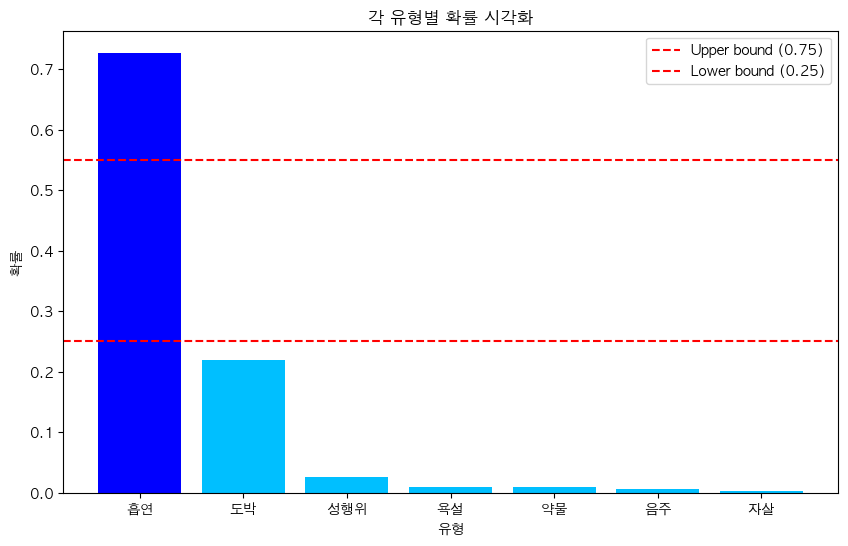

In [158]:
visualize(res, pros, upperbound, lowerbound)